# Final evaluation of model paths

In [1]:
models = ["cafe", "pgpr"]
dataset = "lfm"

In [2]:
from random import seed, randint, choice
from collections import defaultdict
import pickle
import numpy as np

### Some basic evaluation functions

In [3]:
def dcg_at_k(topk, k, method=1):
    topk = np.asfarray(topk)[:k]
    if topk.size:
        if method == 0:
            return topk[0] + np.sum(topk[1:] / np.log2(np.arange(2, topk.size + 1)))
        elif method == 1:
            return np.sum(topk / np.log2(np.arange(2, topk.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.

def ndcg_at_k(topk, k, method=1):
    dcg_max = dcg_at_k(sorted(topk, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(topk, k, method) / dcg_max

def recall_at_k(topk, test_pids):
    return sum(topk) / len(test_pids)
    
def precision_at_k(topk, k):
    return sum(topk) / k

In [4]:
def path_len(path):
    len = 0
    for s in path:
        if type(s) != str:
            s = str(s)
        if s.isnumeric():
            len+=1
    return len

# Path Structure: user 5038 watched product 2430 watched user 1498 watched product 1788
def template(curr_model, path):
    if path[0] == "self_loop":
        path = path[1:]

    path_length = path_len(path)
    for i in range(1, len(path)):
        s = str(path[i])
        if s.isnumeric():
            if path[i-1] == 'user': continue
            if int(path[i]) not in entity2name[curr_model][path[i-1]]: continue
            path[i] = entity2name[curr_model][path[i-1]][int(path[i])]
    if path_length == 4:
        _, uid, rel_0, e_type_1, e_1, rel_1, e_type_2, e_2, rel_k, _, pid  = path
        return f"{pid} is recommend to you because you {rel_0} {e_1} also {rel_k} by {e_2}"
    elif path_len(path) == 3:
        _, uid, rel_0, e_type_1, e_1, rel_1, _, pid  = path
        return f"{pid} is recommend to you because is {r_k} with {e_1} that you previously {rel_0}"

In [94]:
from knowledge_graph_utils import entity2plain_text
entity2name = {}
entity2name["cafe"] = entity2plain_text(dataset, "cafe")
entity2name["pgpr"] = entity2plain_text(dataset, "pgpr")

### Load train and test labels for each model

In [95]:
train_labels = {}
test_labels = {}

In [96]:
model_name = "pgpr"
%cd models/PGPR
from pgpr_utils import load_labels

train_labels[model_name] = load_labels(dataset, 'train')
test_labels[model_name] = load_labels(dataset, 'test')
%cd ../..


/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/PGPR
/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src


In [97]:
model_name = "cafe"
%cd models/CAFE

from cafe_utils import load_labels

train_labels[model_name] = load_labels(dataset, 'train')
test_labels[model_name] = load_labels(dataset, 'test')
%cd ../..

/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src/models/CAFE
/home/jfallmann/userdata/Bachelor Thesis/bachelor-thesis/src


In [120]:
def load_paths(model):
    with open(f"results/lfm/{model}/pred_paths.pkl", 'rb') as pred_paths_file:
        paths = pickle.load(pred_paths_file)
    pred_paths_file.close()
    
    pred_paths_map = defaultdict(dict)
    for record in paths:
        uid, pid, path_score, path_prob, path = record
        if pid not in pred_paths_map[uid]:
            pred_paths_map[uid][pid] = []
        pred_paths_map[uid][pid].append((float(path_score), float(path_prob), path))
    return pred_paths_map

In [136]:
def select_best_paths(pred_paths_map, model):
    best_pred_paths = {}
    for uid in pred_paths_map:
        if uid in train_labels[model]:
            train_pids = set(train_labels[model][uid])
        else:
            print("Invalid train_pids")
        best_pred_paths[uid] = []
        for pid in pred_paths_map[uid]:
            if pid in train_pids:
                continue
            # Get the path with highest probability
            sorted_path = sorted(pred_paths_map[uid][pid], key=lambda x: x[1], reverse=True)
            best_pred_paths[uid].append(sorted_path[0])
    return best_pred_paths

In [163]:
def paths_for_top_k(model, best_paths, k):
    ndcgs = []
    recalls = []
    precisions = []
    users_topk = defaultdict(list)
    if model == "pgpr":
        for uid in range(len(best_paths.keys())):
            sorted_paths = sorted(best_paths[uid], key=lambda x: (x[0], x[1]), reverse=True)
            sorted_paths = [[path[0], path[1], path[-1].split(" ")] for path in sorted_paths]
            topk_products = [int(path[-1][-1]) for path in sorted_paths[:k]]
            topk_explanations = [path[-1] for path in sorted_paths[:k]]
            users_topk[uid] = list(zip(topk_products, topk_explanations))
    elif model == "cafe":
        for uid, pids in best_paths.items():
            user_paths = []
            for paths in pids.values():
                user_paths.extend(paths)
            sorted(user_paths, key=lambda x: x[0], reverse=True)
            users_topk[uid] = [(path[-1][-1], path[-1]) for path in user_paths[:k]]
        
    for uid, rec_exp_tuples in users_topk.items():
        hits = []
        for rec_exp_tuple in rec_exp_tuples:
            recommended_pid = rec_exp_tuple[0]
            if recommended_pid in test_labels[model][uid]:
                hits.append(1)
            else:
                hits.append(0)
        while len(hits) < 10:
            hits.append(0)
        ndcg = ndcg_at_k(hits, k)
        precision = precision_at_k(hits, k)
        recall = recall_at_k(hits, test_labels[model][uid])
        ndcgs.append(ndcg)
        precisions.append(precision)
        recalls.append(recall)
    print(f"Overall NDGC: {np.mean(ndcgs)}, Precision: {np.mean(precisions)}, Recall: {np.mean(recalls)}")
    return users_topk

## Evaluate basic path properties

In [205]:
model_name = "pgpr"

In [206]:
pred_paths_map_pgpr = load_paths(model_name)

In [207]:
n_users = len(pred_paths_map_pgpr.keys())
random_user = randint(0, n_users)
random_product = choice(list(pred_paths_map_pgpr[random_user].keys()))
print(pred_paths_map_pgpr[random_user][random_product])
print(len(pred_paths_map_pgpr[random_user]))

[(0.5451194614368495, 4.844496288569644e-05, 'self_loop user 5770 listened_to product 105127 listened_to user 4785 listened_to product 169798')]
352


In [208]:
best_paths = select_best_paths(pred_paths_map_pgpr, model_name)

In [209]:
random_user = randint(0, n_users)
print(best_paths[random_user][:5])

[(0.7131884844965696, 0.0022902332711964846, 'self_loop user 4006 listened_to product 41487 listened_to user 2512 listened_to product 169252'), (0.4812971786408222, 0.0015554121928289533, 'self_loop user 4006 listened_to product 41487 listened_to user 4650 listened_to product 171633'), (0.6033754706897787, 0.00048558987327851355, 'self_loop user 4006 listened_to product 41487 listened_to user 1426 listened_to product 169270'), (0.7067092899563824, 0.0012424252927303314, 'self_loop user 4006 listened_to product 41487 listened_to user 4988 listened_to product 167983'), (0.7630806581449604, 0.006331761833280325, 'self_loop user 4006 listened_to product 71463 listened_to user 9377 listened_to product 169533')]


In [210]:
k = 10
users_topk = paths_for_top_k(model_name, best_paths, k)

Overall NDGC: 0.09202033030883408, Precision: 0.02277102062400846, Recall: 0.002607531456789202


In [211]:
users_topk

defaultdict(list,
            {0: [(169533,
               ['self_loop',
                'user',
                '0',
                'listened_to',
                'product',
                '21960',
                'listened_to',
                'user',
                '2512',
                'listened_to',
                'product',
                '169533']),
              (166370,
               ['self_loop',
                'user',
                '0',
                'listened_to',
                'product',
                '41309',
                'listened_to',
                'user',
                '2955',
                'listened_to',
                'product',
                '166370']),
              (169005,
               ['self_loop',
                'user',
                '0',
                'listened_to',
                'product',
                '80354',
                'listened_to',
                'user',
                '2494',
                'listened_to',

In [212]:
relation_counts = {}

In [213]:
relation_counts[model_name] = {}
for user in users_topk:
    for i in range(len(users_topk[user])):
        relation = users_topk[user][i][1][6]
        if relation not in relation_counts[model_name]:
            relation_counts[model_name][relation] = 1
        else:
            relation_counts[model_name][relation] = relation_counts[model_name][relation] + 1

In [214]:
relation_counts[model_name]

{'listened_to': 92362,
 'has_micro_genre': 1905,
 'has_genre': 77,
 'in_album': 114,
 'created_by': 92}

In [215]:
model_name = "cafe"

predicted_paths = load_paths(model_name)
users_topk = paths_for_top_k(model_name, predicted_paths, k)


Overall NDGC: 0.07641083248013784, Precision: 0.01965097831835008, Recall: 0.003043877015559237


In [216]:
len(predicted_paths[4000])

6

In [222]:
relation_counts[model_name] = {}
for user in users_topk:
    for i in range(len(users_topk[user])):
        relation = users_topk[user][i][1][5]
        if relation == "rev_listened":
            relation = "listened_to"
        if relation not in relation_counts[model_name]:
            relation_counts[model_name][relation] = 1
        else:
            relation_counts[model_name][relation] = relation_counts[model_name][relation] + 1

In [223]:
relation_counts[model_name]

{'listened_to': 43516,
 'has_micro_genre': 28467,
 'has_genre': 13149,
 'created_by': 699,
 'in_album': 502}

In [219]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set() 

In [224]:
pd.DataFrame(relation_counts)

,pgpr,cafe
listened_to,92362,43516
has_micro_genre,1905,28467
has_genre,77,13149
in_album,114,502
created_by,92,699


Text(0.5, 1.0, 'CAFE')

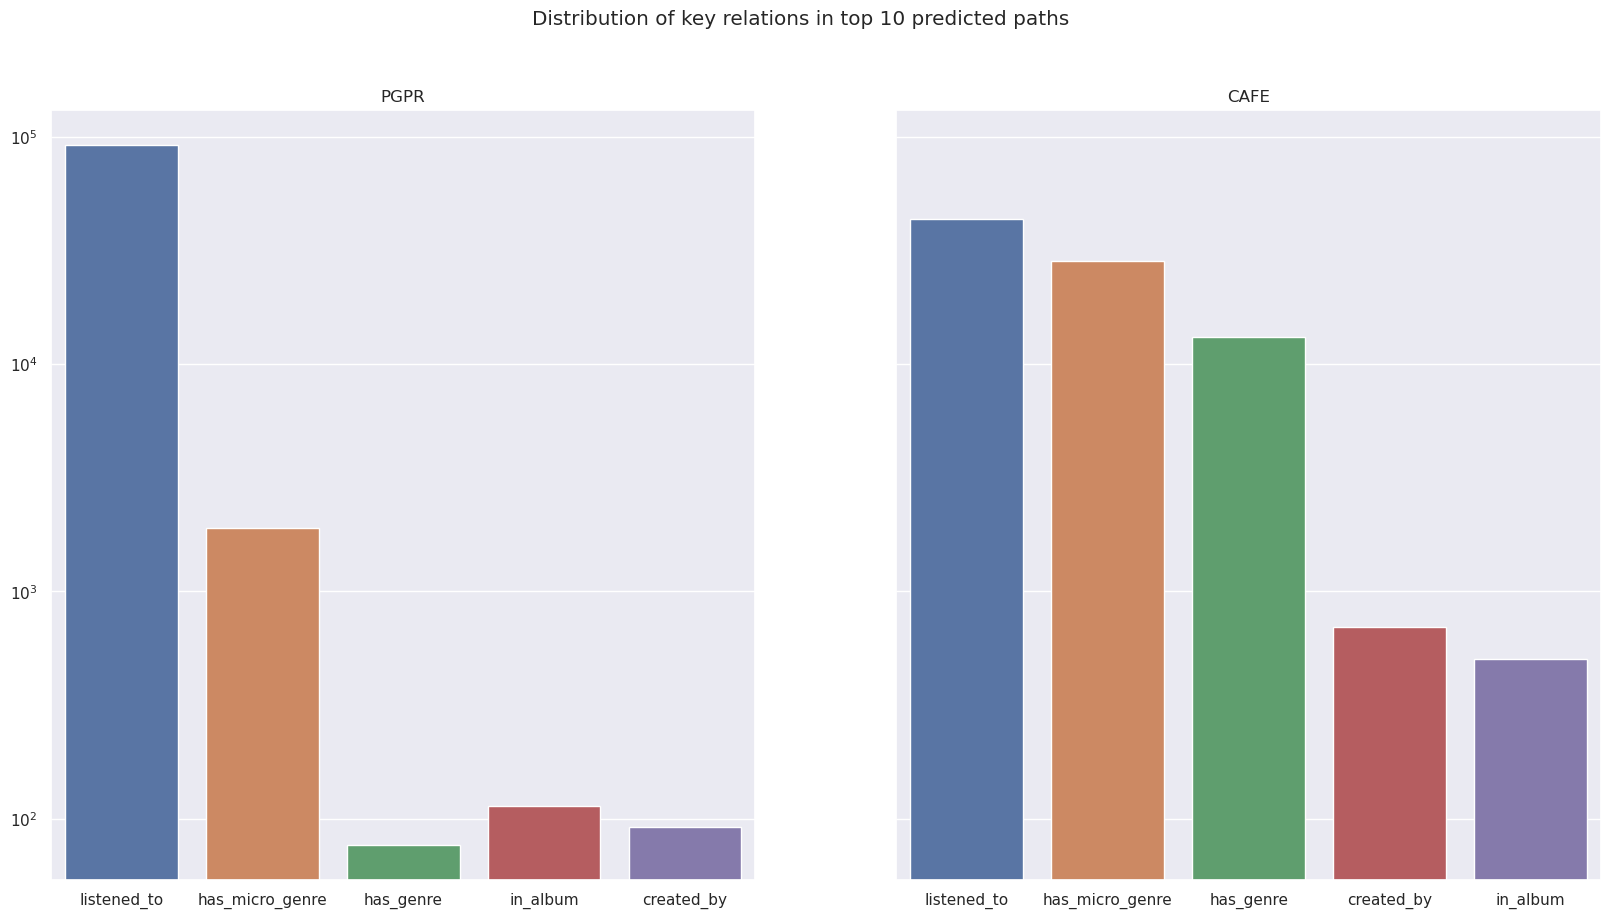

In [235]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10), sharey='row')

fig.suptitle("Distribution of key relations in top 10 predicted paths")
g = sns.barplot(ax=ax1, x=list(relation_counts["pgpr"].keys()), y=[relation_counts["pgpr"][k] for k in relation_counts["pgpr"].keys()])
g.set_yscale("log")
ax1.set_title("PGPR")

g = sns.barplot(ax=ax2, x=list(relation_counts["cafe"].keys()), y=[relation_counts["cafe"][k] for k in relation_counts["cafe"].keys()])
g.set_yscale("log")
ax2.set_title("CAFE")


## Divide users into age bins

A common choice of age bins is the following
0-17 (Children and adolescents)
18-34 (young adults)
35-49 (Middle aged adults)
50-64 (middle aged to adults)
65-79 (Older adults)
80+ (Elderly)

In [252]:
age_bins = [
    {
        "name": "Children and dolescents",
        "min": 0,
        "max": 17
    },
    {
        "name": "Young adults",
        "min": 18,
        "max": 34
    },
    {
        "name": "Middle aged adults",
        "min": 35,
        "max": 49
    },
    {
        "name": "Middle aged to older adults",
        "min": 50,
        "max": 64
    },
    {
        "name": "Older adults",
        "min": 65,
        "max": 79
    },
    {
        "name": "Elderly",
        "min": 80,
        "max": 100
    }
]

In [266]:
gender_bins = [
    {
        "name": "male",
        "gender": "m"
    },
    {
        "name": "female",
        "gender": "f"
    }
]

In [237]:
users = pd.read_csv('data/lfm/cleaned/users.tsv', sep='\t')
users.head()

,user_id,country,age,gender,creation_time
0,2,UK,35,m,2002-10-29 01:00:00
1,14,UK,48,m,2003-02-18 21:44:13
2,15,US,28,m,2003-02-24 03:30:33
3,36,UK,29,m,2003-03-27 12:17:12
4,42,RU,30,m,2003-04-10 01:07:48


In [239]:
user_id_mapping = pd.read_csv('data/lfm/preprocessed/users.txt', sep="\t")
user_id_mapping.head()

,new_id,raw_dataset_id
0,0,2
1,1,14
2,2,15
3,3,36
4,4,42


In [249]:
# Map the user ids to the internal ids used in the paths
users.user_id = users.user_id.apply(lambda id: user_id_mapping[user_id_mapping.raw_dataset_id == id].new_id.to_numpy()[0])

In [250]:
users.head()

,user_id,country,age,gender,creation_time
0,0,UK,35,m,2002-10-29 01:00:00
1,1,UK,48,m,2003-02-18 21:44:13
2,2,US,28,m,2003-02-24 03:30:33
3,3,UK,29,m,2003-03-27 12:17:12
4,4,RU,30,m,2003-04-10 01:07:48


In [271]:
for age_bin in age_bins:
    age_bin["user_ids"] = users[(users.age >= age_bin["min"]) & (users.age <= age_bin["max"])].user_id.to_numpy()
    age_bin["total_count"] = len(age_bin["user_ids"])

{'name': 'Children and dolescents', 'min': 0, 'max': 17, 'user_ids': array([1533, 2194, 2493, 2878, 3132, 3197, 3257, 3259, 3380, 3483, 3595,
       3977, 4108, 4208, 4394, 4405, 4501, 4506, 4584, 4693, 4720, 4835,
       4885, 4895, 4922, 4926, 4975, 5025, 5026, 5134, 5141, 5161, 5168,
       5179, 5202, 5208, 5221, 5228, 5267, 5293, 5330, 5337, 5353, 5406,
       5420, 5440, 5468, 5483, 5601, 5637, 5653, 5660, 5705, 5719, 5736,
       5759, 5783, 5817, 5892, 5927, 5945, 5996, 5997, 6040, 6046, 6053,
       6080, 6099, 6101, 6135, 6160, 6182, 6187, 6201, 6220, 6259, 6264,
       6273, 6280, 6316, 6337, 6346, 6360, 6413, 6417, 6422, 6431, 6440,
       6446, 6447, 6459, 6465, 6468, 6473, 6480, 6486, 6493, 6538, 6541,
       6564, 6568, 6570, 6584, 6598, 6599, 6608, 6616, 6632, 6642, 6660,
       6662, 6685, 6687, 6702, 6721, 6761, 6773, 6774, 6816, 6848, 6854,
       6857, 6867, 6871, 6880, 6908, 6921, 6931, 6932, 6933, 6945, 6964,
       6980, 6993, 6996, 7014, 7055, 7068, 7070, 7078, 

In [272]:
for gender_bin in gender_bins:
    gender_bin["user_ids"] = users[users.gender == gender_bin["gender"]].user_id.to_numpy()
    gender_bin["total_count"] = len(gender_bin["user_ids"])

{'name': 'male', 'gender': 'm', 'user_ids': array([   0,    1,    2, ..., 9449, 9451, 9452])}
{'name': 'female', 'gender': 'f', 'user_ids': array([   5,    7,   20, ..., 9450, 9453, 9454])}


In [273]:
gender_bins

[{'name': 'male',
  'gender': 'm',
  'user_ids': array([   0,    1,    2, ..., 9449, 9451, 9452]),
  'total_count': 7679},
 {'name': 'female',
  'gender': 'f',
  'user_ids': array([   5,    7,   20, ..., 9450, 9453, 9454]),
  'total_count': 1776}]